### CIFAR-100 Image Classification Analysis

**Problem Statement**:

The primary objective of this project is to develop a highly accurate image classification model utilizing the CIFAR-100 dataset. This dataset comprises 60,000 color images, each measuring 32x32 pixels, and is organized into 100 distinct classes. Our aim is to leverage state-of-the-art deep learning techniques to construct and optimize a model that not only achieves superior classification accuracy but also has the capability to classify any images uploaded by users into these defined classes.

By focusing on advanced methodologies in deep learning, we seek to explore various architectures, optimize hyperparameters, and implement effective data preprocessing techniques. This approach will enable us to enhance the model's performance, ensuring it can reliably distinguish between the diverse categories represented in the CIFAR-100 dataset. Ultimately, this project aspires to contribute valuable insights into image classification and provide a robust tool for real-time image analysis.

**Objectives**:

**Build an Accurate Classifier**: Our primary objective is to develop a robust model that can effectively classify images from the CIFAR-100 dataset into one of the 100 specific classes.

**Optimize Model Performance**: We will explore various architectures and fine-tune hyperparameters to enhance the model's accuracy and overall performance.

**Visualize Model Insight**: To better understand the model's performance, we will create visualizations that elucidate how the model makes its predictions and where it may struggle.

**Deploy the Model**: A key aspect of this project is to create a user-friendly interface that allows for real-time image classification, making the model accessible to users.

**Validate Hypotheses**: We will conduct systematic testing of our hypotheses regarding model performance and feature importance, ensuring that our findings are robust.

### Importing necessary libraries

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# Image processing
from PIL import Image
from sklearn.model_selection import train_test_split

# Additional utilities
import os
import random
import tarfile
import pickle






**Downloading CIFAR-100 Dataset**:
using TensorFlow or PyTorch datasets API for easy access.
For TensorFlow:
Download code commented out after downloading so as not to download again each time I run notebook

In [2]:
# (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [3]:
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

In [4]:
# # Save the dataset locally in a compressed format
# np.savez_compressed("cifar100_data.npz", x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

#### Load data after downloading

In [5]:
# Base directory path
base_path = r"C:\Users\USER\3Signet_2"  # Use absolute path for clarity
data_tar_path = os.path.join(base_path, "cifar-100-python.tar.gz")
data_npz_path = os.path.join(base_path, "cifar100_data.npz")
data_extract_path = os.path.join(base_path, "cifar-100-python")

# Check if the data is already saved in .npz format for quicker loading
if os.path.exists(data_npz_path):
    print(f"Found preprocessed .npz file at: {data_npz_path}")
    # Load from .npz file if it exists
    data = np.load(data_npz_path)
    x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']
else:
    print(f"No preprocessed file found. Checking tar file at: {data_tar_path}")

    # Check if the tar file exists
    if not os.path.exists(data_tar_path):
        raise FileNotFoundError(f"The dataset tar file is missing. Please ensure it exists at: {data_tar_path}")
    
    # Extract if not already done
    if not os.path.isdir(data_extract_path):
        print(f"Extracting dataset from {data_tar_path}...")
        with tarfile.open(data_tar_path, "r:gz") as tar:
            tar.extractall(path=base_path)
        print(f"Dataset extracted to: {data_extract_path}")

    # Function to load data from CIFAR-100 file
    def load_cifar100_batch(file_path):
        print(f"Loading data from: {file_path}")
        with open(file_path, 'rb') as file:
            batch = pickle.load(file, encoding='bytes')
        return batch

    # Load training and testing data from the extracted files
    train_file_path = os.path.join(data_extract_path, "train")
    test_file_path = os.path.join(data_extract_path, "test")

    if not os.path.exists(train_file_path) or not os.path.exists(test_file_path):
        raise FileNotFoundError("Expected train or test files missing in the extracted dataset.")

    train_data = load_cifar100_batch(train_file_path)
    test_data = load_cifar100_batch(test_file_path)

    # Reshape and transpose data to (num_samples, 32, 32, 3)
    print("Reshaping and transposing training and testing data...")
    x_train = np.array(train_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_train = np.array(train_data[b'fine_labels'])
    x_test = np.array(test_data[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_data[b'fine_labels'])

    # Save data as .npz for future quick loading
    print(f"Saving processed data to: {data_npz_path}")
    np.savez_compressed(data_npz_path, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Found preprocessed .npz file at: C:\Users\USER\3Signet_2\cifar100_data.npz


#### Data Exploration

In [6]:
# Print data shapes for verification
print("Data successfully loaded!")
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data successfully loaded!
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000,)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000,)


x_train.shape:
50000: This indicates that there are 50,000 training images in the dataset.
32, 32: Each image is 32 pixels in height and 32 pixels in width.
3: This indicates the number of color channels (RGB) in each image. So, each image has three layers corresponding to the red, green, and blue components.

y_train.shape:
50000: There are 50,000 labels corresponding to the training images.
1: Each label is an integer that represents the class of the image. Therefore, the labels are structured as a single-column array with 50,000 entries.
Test Data: (10000, 32, 32, 3) and (10000, 1)

x_test.shape:
10000: This indicates that there are 10,000 test images in the dataset.
32, 32: Each test image also measures 32 pixels in height and 32 pixels in width.
3: Like the training set, each test image has three color channels (RGB).

y_test.shape:
10000: There are 10,000 labels corresponding to the test images.
1: Each label in the test set is similarly structured, representing the class of each respective image.


### Sample plotting a few images

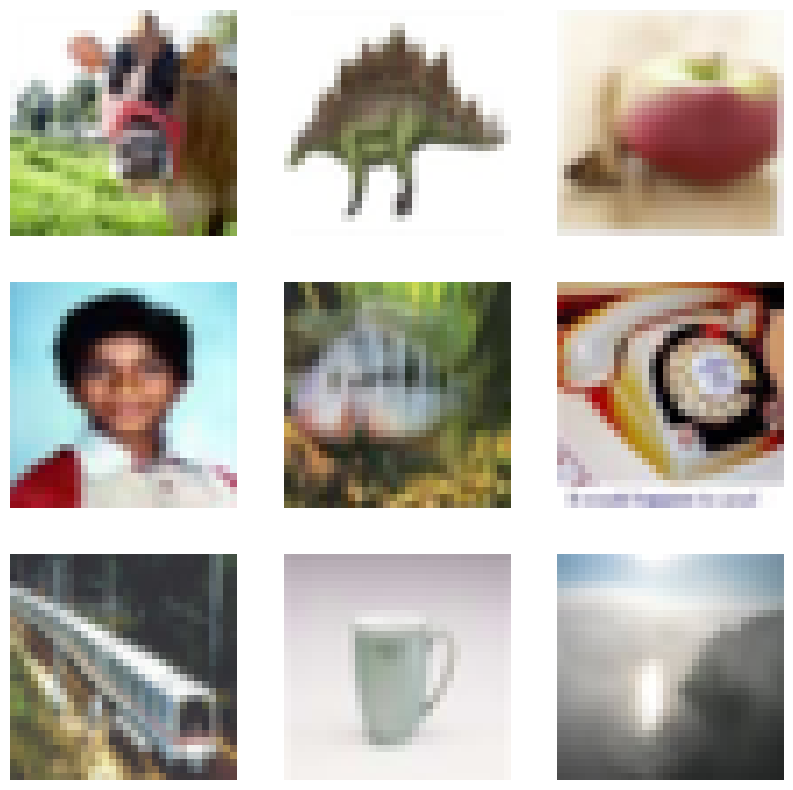

In [7]:
# Assuming you have loaded the data as x_train
# Let's plot the first 9 images from the training set
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
plt.show()

**Check for class distribution**

Each bar has a uniform height, indicating that each class within the CIFAR-100 dataset has an equal number of samples—specifically, 500 samples per class and class labels ranging from 0 to 99, indicating 100 distinct classes.


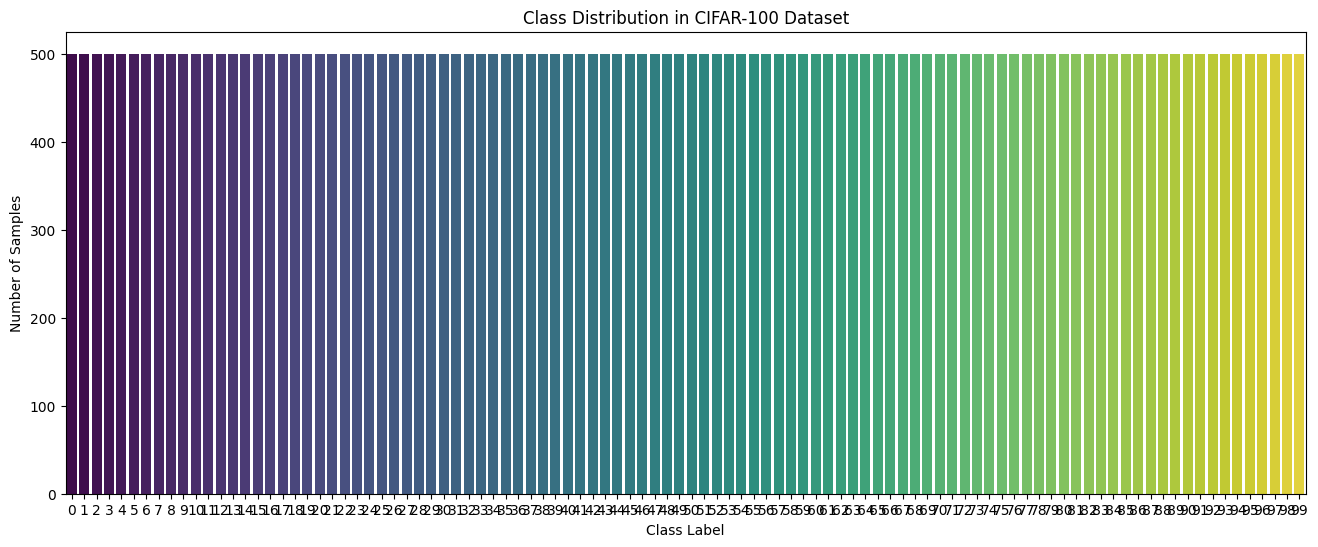

In [8]:
# Flatten the labels array for easier counting
y_train = y_train.flatten()

# Count occurrences of each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot class distribution
plt.figure(figsize=(16, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), hue=list(class_counts.keys()), palette="viridis", legend=False)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in CIFAR-100 Dataset")
plt.show()

In [9]:
print(f"Pixel Value Range (Training): Min={x_train.min()}, Max={x_train.max()}")
print(f"Pixel Value Range (Testing): Min={x_test.min()}, Max={x_test.max()}")

Pixel Value Range (Training): Min=0, Max=255
Pixel Value Range (Testing): Min=0, Max=255


In [10]:
# Number of classes
num_classes = len(np.unique(y_train))
print(f"Number of unique classes: {num_classes}")

Number of unique classes: 100


#### Data Preprocessing

In [11]:
# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0
print(f"Normalized pixel range: {x_train.min()} to {x_train.max()}")

Normalized pixel range: 0.0 to 1.0


In [12]:
# One-hot encoding labels
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
print(f"Shape of y_train_one_hot: {y_train_one_hot.shape}")

Shape of y_train_one_hot: (50000, 100)


In [13]:
# Split training data into training and validation sets
x_train, x_val, y_train_one_hot, y_val_one_hot = train_test_split(
    x_train, y_train_one_hot, test_size=0.2, random_state=42
)
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val_one_hot: {y_val_one_hot.shape}")

Shape of x_val: (10000, 32, 32, 3)
Shape of y_val_one_hot: (10000, 100)


In [14]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
)
datagen.fit(x_train)

In [15]:
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.15,
#     brightness_range=[0.8, 1.2],
# )
# datagen.fit(x_train)

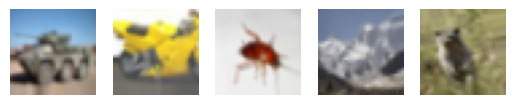

In [16]:
# Example of augmented images
augmented_images = next(datagen.flow(x_train, batch_size=5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#### Develop Baseline Deep Learning Models

In [24]:
def build_baseline_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=input_shape))
    
    # Convolutional and pooling layers with BatchNormalization and Dropout
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


# Define input shape and number of classes
input_shape = (32, 32, 3)
num_classes = 100

# Build and summarize the baseline model
baseline_model = build_baseline_model(input_shape, num_classes)
baseline_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          25,700 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 644,388 (2.46 MB)

 Trainable params: 643,940 (2.46 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Compile the model
baseline_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "best_baseline_model.keras",  # Change .h5 to .keras
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model
history = baseline_model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=64),
    validation_data=(x_val, y_val_one_hot),
    epochs=50,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 267ms/step - accuracy: 0.0134 - loss: 4.5905 - val_accuracy: 0.0259 - val_loss: 4.4400 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 174s 277ms/step - accuracy: 0.0225 - loss: 4.4813 - val_accuracy: 0.0356 - val_loss: 4.3379 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 325ms/step - accuracy: 0.0316 - loss: 4.3874 - val_accuracy: 0.0637 - val_loss: 4.1876 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 295ms/step - accuracy: 0.0384 - loss: 4.3135 - val_accuracy: 0.0745 - val_loss: 4.1304 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 177s 280ms/step - accuracy: 0.0481 - loss: 4.2481 - val_accuracy: 0.0885 - val_loss: 4.0394 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 181s 287ms/step - accuracy: 0.0548 - loss: 4.2003 - val_accuracy: 0.0926 - val_loss: 3.9856 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 297ms/step - accura

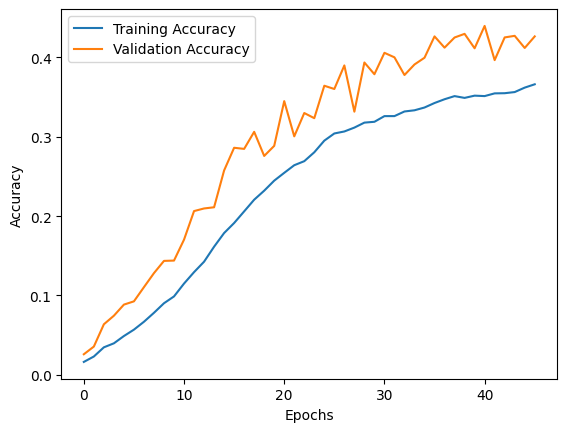

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

####  Improving Model Capacity with ResNet50 as base model

In [29]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [37]:
def create_pretrained_model():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze the base model

    # Add custom layers on top
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(100, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_pretrained_model()
model.summary()


Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)    │ (None, 32, 32, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 38, 38, 3)         │               0 │ input_layer_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 16, 16, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 16, 16, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 16, 16, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 18, 18, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 8, 8, 64)          │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 8, 8, 64)          │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 8, 8, 64)          │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 8, 8, 64)          │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 8, 8, 64)          │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 8, 8, 256)         │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,137,956 (92.08 MB)

 Trainable params: 550,244 (2.10 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [38]:
# Train the model
model = create_pretrained_model()
history = model.fit(
    datagen.flow(x_train, y_train_one_hot, batch_size=64),  # Use one-hot labels
    validation_data=(x_val, y_val_one_hot),  # Use one-hot labels
    epochs=50,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 438s 640ms/step - accuracy: 0.0098 - loss: 4.6628 - val_accuracy: 0.0086 - val_loss: 4.6057 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 377s 601ms/step - accuracy: 0.0094 - loss: 4.6054 - val_accuracy: 0.0087 - val_loss: 4.6062 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 411s 657ms/step - accuracy: 0.0094 - loss: 4.6053 - val_accuracy: 0.0082 - val_loss: 4.6065 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 411s 655ms/step - accuracy: 0.0103 - loss: 4.6054 - val_accuracy: 0.0082 - val_loss: 4.6066 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 403s 644ms/step - accuracy: 0.0092 - loss: 4.6052 - val_accuracy: 0.0090 - val_loss: 4.6054 - learning_rate: 5.0000e-04
